<font face='serif' size=4>
<span style="line-height: 1.25;">

# HW9 for Statistics with Meteorological Application
---
Student: 林之然 (B11209005, 大氣二), 蔡知諺（B11209014, 大氣二）

<font face='serif' size=4>
<span style="line-height: 1.25;">

### Preparing

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Import necessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging
import time

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Check mps is avaliable

In [3]:
# Check mps is avaliable
if not torch.backends.mps.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('mps')

print(f"Using device: {device}")

Using device: mps


<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Fix random seed

In [4]:
# Set random seed
seed_np = np.random.seed(2)
seed = torch.manual_seed(2)

<font face='serif' size=4>
<span style="line-height: 1.25;">

### Implementation

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Hyperparameters

In [5]:
# Hyperparameters
params = {
    "lr": 1e-6,
    "weight_decay": 1e-7,
    "epochs": 2000,
    "batch_size": 64,
    "num_workers": 0,  # Have some problems with num_workers > 0, because of multiple cells in jupyter notebook.
    "eval_rate": 0.2,
}

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Process data

Slice the global sea surface temperature (SST) data within the bounds of 5°S to 5°N and 120°W to 170°W base on definition of nino3.4.

In [6]:
# Load SST data
data_path = './sst.mon.mean.trefadj.anom.1880to2018.nc'
ds = xr.open_dataset(data_path)

# Slice the data (lat 85~95 for 5S~5N degrees, lon 190~240 for 120W~170W degrees)
sst_train = ds['sst'].sel(time=slice('1960-01-01', '2005-12-31')).isel(lat=slice(85, 95), lon=slice(190, 240))
sst_test = ds['sst'].sel(time=slice('2007-01-01', '2017-12-31')).isel(lat=slice(85, 95), lon=slice(190, 240))

# Convert to numpy arrays and reshape for model input
X_train = sst_train.values.reshape(-1, 1, sst_train.shape[1], sst_train.shape[2])
X_test = sst_test.values.reshape(-1, 1, sst_test.shape[1], sst_test.shape[2])

# Normalize the training and testing datasets
mean = X_train.mean()
std = X_train.std()
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

# Load and process label data
label_data_path = './nino34.long.anom.data.txt'
sst_labels = pd.read_csv(label_data_path, delim_whitespace=True, header=None)
sst_labels.columns = ['Year'] + [f'Month_{i}' for i in range(1, 13)]
sst_labels = sst_labels.set_index('Year')

# Extract labels for training and testing
y_train = sst_labels.loc[1960:2005].to_numpy().flatten()
y_test = sst_labels.loc[2007:2017].to_numpy().flatten()

# Define the dataset class for PyTorch
class SSTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Split the training data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X_train_normalized, y_train, test_size=params["eval_rate"], random_state=seed_np)

# Initialize DataLoader objects
train_loader = DataLoader(SSTDataset(X_train, y_train), batch_size=params["batch_size"], shuffle=True)
eval_loader = DataLoader(SSTDataset(X_eval, y_eval), batch_size=params["batch_size"], shuffle=False)
test_loader = DataLoader(SSTDataset(X_test_normalized, y_test), batch_size=params["batch_size"], shuffle=False)

# Output shapes for confirmation
print(X_train.shape, y_train.shape)
print(X_eval.shape, y_eval.shape)
print(X_test_normalized.shape, y_test.shape)

(441, 1, 10, 50) (441,)
(111, 1, 10, 50) (111,)
(132, 1, 10, 50) (132,)


<font face='serif' size=4>
<span style="line-height: 1.25;">

#### 9.2 Define model

The CNN model includes two convolutional layers, each followed by a max pooling layer to reduce the feature maps' spatial dimensions. The first convolutional layer maps a single-channel input to 16 feature maps, while the second increases these to 32. Post pooling, the data is flattened and processed through two linear layers. The first reduces the dimension to 128, and the second outputs a single continuous value, indicating the model is designed for a regression task.

In [7]:
# Define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.num_flat_features = 32 * (10 // 4) * (50 // 4)
        self.fc1 = nn.Linear(self.num_flat_features, 128)
        self.fc2 = nn.Linear(128, 1)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features)  # Flatten the output of the last convolutional layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output a single logit for regression
        return x

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Configurations

Here, we use MSE loss as the loss function for the regression task.

In [8]:
# Initialize model, optimizer, and loss function
model = CNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
criterion = nn.MSELoss()  # Mean squared error loss for regression

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### Training and Testing

Implement `Early stopping` based on the evaluation loss. Set a threshold to trigger early stopping.

(For this setup, we use a high threshold and numerous epochs to intentionally allow the training process to overfit. But we still save the best model for prediction)

In [9]:
# Configure logging
logging.basicConfig(filename='training_v2.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Arrays to keep track of train and test losses
train_losses = np.zeros(params["epochs"])
eval_losses = np.zeros(params["epochs"])

def train_model():
    logging.info(f'Starting training, Epochs: {params["epochs"]}, Batch Size: {params["batch_size"]}, Learning Rate: {params["lr"]}, Weight Decay: {params["weight_decay"]}')
    best_train_loss = float('inf')
    start_time = time.time()

    # Training loop
    for epoch in tqdm(range(params["epochs"]), desc='Training progress'):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Ensure outputs are of correct shape
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Record the training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses[epoch] = avg_train_loss

        # Log the epoch results
        message = f'Epoch {epoch + 1}/{params["epochs"]}: Train Loss: {avg_train_loss:.4f}'
        logging.info(message)
        
        # Evaluate the model
        model.eval()
        running_eval_loss = 0.0
        with torch.no_grad():
            for inputs, labels in eval_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                running_eval_loss += loss.item()
                
        # Record the evaluation loss
        avg_eval_loss = running_eval_loss / len(eval_loader)
        eval_losses[epoch] = avg_eval_loss
                
        # Log the evaluation results
        message = f'Epoch {epoch + 1}/{params["epochs"]}: Eval Loss: {avg_eval_loss:.4f}'
        logging.info(message)
        
        # Save the best model if the evaluation loss decreases
        if avg_eval_loss < best_train_loss:
            best_train_loss = avg_eval_loss
            torch.save(model.state_dict(), 'best_model_v2.pth')
            logging.info('  Eval loss decreased, saving model...')
            
        # Early stopping
        if epoch > 2000 and eval_losses[epoch] > eval_losses[epoch - 100]:
            logging.info('Early stopping')
            print('Early stopping')
            break
              
    # Training complete  
    train_time = time.time() - start_time
    print(f'Training time for {epoch + 1} epochs: {train_time:.2f} seconds')


def test_model(model_path='best_model_v2.pth'):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  # Ensure outputs are of correct shape
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    print(f'Test MSE Loss: {avg_test_loss:.4f}')


train_model()
test_model()

Training progress: 100%|██████████| 2000/2000 [01:17<00:00, 25.74it/s]


Training time for 2000 epochs: 77.72 seconds
Test MSE Loss: 0.0297


<font face='serif' size=4>
<span style="line-height: 1.25;">

#### 9.4 Visualize training result
Adjust the `ylim` to better visualize the details of the loss curve, where signs of overfitting may be observed. Specifically, as the training loss continues to decrease and the validation loss begins to increase, it indicates a decline in the model's performance with further training.

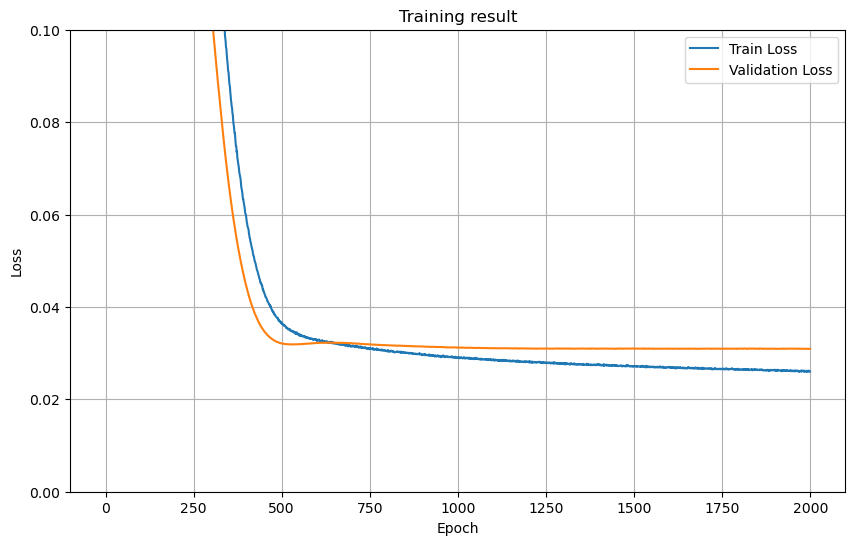

In [10]:
# Plot training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.1)  # to see overfitting
plt.title("Training result")
plt.legend()
plt.savefig('hw9_training_result_v2.png')
plt.grid()
plt.show()

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### 9.1, 9.3 Plot predicted Nino34 and calculate the correlation

Correlation between true and predicted Nino3.4 index: 0.9914


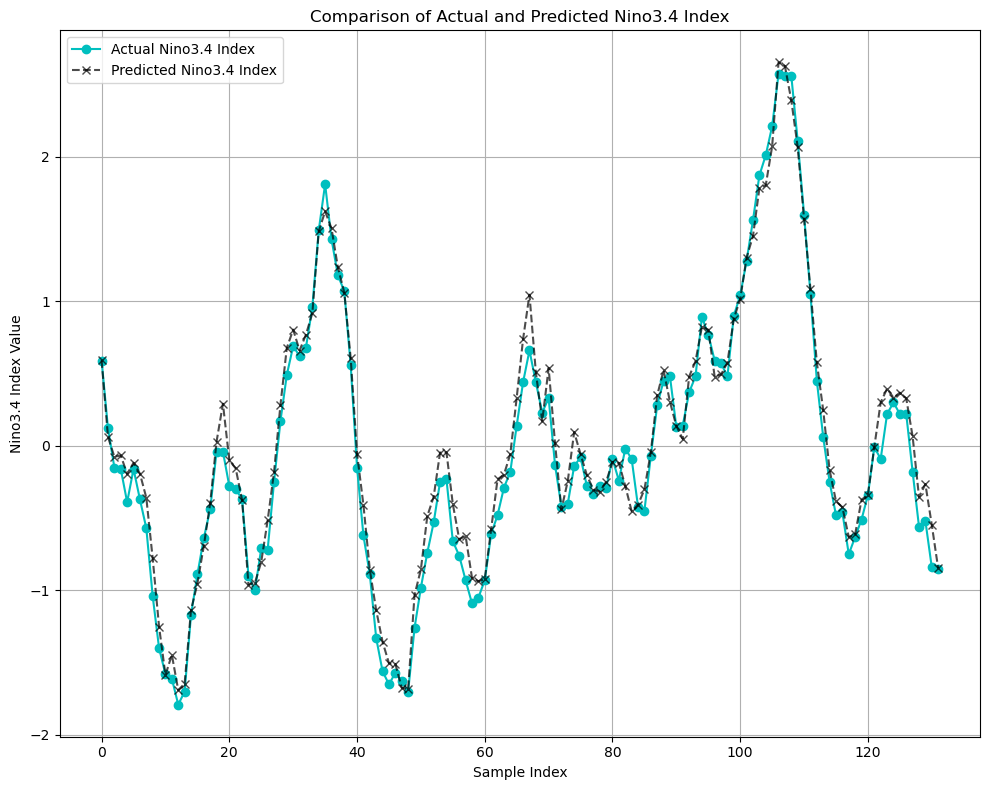

In [11]:
def test_model(model_path='best_model_v2.pth'):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  # Ensure the output is of correct shape
            predictions.extend(outputs.detach().cpu().numpy()) # Move to CPU and convert to NumPy
            actuals.extend(labels.detach().cpu().numpy())

    return predictions, actuals


def plot_results(predictions, actuals):
    plt.figure(figsize=(10, 8))
    plt.plot(actuals, label='Actual Nino3.4 Index', color='c', marker='o')
    plt.plot(predictions, label='Predicted Nino3.4 Index', color='k', linestyle='--', marker='x', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Nino3.4 Index')
    plt.xlabel('Sample Index')
    plt.ylabel('Nino3.4 Index Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig('hw9_prediction_v2.png')
    plt.show()


def corr(x, y):
    return np.corrcoef(x, y)[0, 1]


predictions, actuals = test_model('best_model_v2.pth')
print(f'Correlation between true and predicted Nino3.4 index: {corr(predictions, actuals):.4f}')
plot_results(predictions, actuals)

<font face='serif' size=4>
<span style="line-height: 1.25;">

#### 9.5 Why CNN works well in this prediction problem, as usually we need huge size of dataset (one sentence)? Can you guess what is CNN doing (one sentence)?

1. CNNs work well in this prediction problem because they can effectively extract hierarchical features from data through their convolutional layers, even with limited samples, by learning reusable patterns.

2. CNN automatically learns and captures spatial hierarchies in data by applying trainable filters and pooling layers, making it ideal for tasks involving images or spatial structures.